In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings

## Get Linear Regression Relevant Info

In [224]:
def process_linreg_data():
    with open('../Data/states_bpleq65.p','rb') as f:
        states = pickle.load(f)
    
    patient_ids = list(states.keys())
    
    pid = patient_ids[0]
    df_clean = states[pid].loc[:,~states[pid].columns.isin(['Times','bicarbonate_ind', 'bun_ind','creatinine_ind',
                                                            'fio2_ind','glucose_ind','hct_ind','hr_ind','lactate_ind',
                                                            'magnesium_ind','meanbp_ind','platelets_ind','potassium_ind',
                                                            'sodium_ind','spo2_ind','spontaneousrr_ind','temp_ind',
                                                            'urine_ind','wbc_ind'])]

    df_clean.insert(0,'ICU_ID',pid)
    df_x_train = df_clean.loc[:,~df_clean.columns.isin(['sofa','oasis','saps'])]
    df_y_train = df_clean[['sofa','oasis','saps']]

    x_train = df_x_train.iloc[0]
    y_train = df_y_train.iloc[0]


    for pid in patient_ids[1:]:
        df_clean = states[pid].loc[:,~states[pid].columns.isin(['Times','bicarbonate_ind', 'bun_ind','creatinine_ind',
                                                                'fio2_ind','glucose_ind','hct_ind','hr_ind','lactate_ind',
                                                                'magnesium_ind','meanbp_ind','platelets_ind','potassium_ind',
                                                                'sodium_ind','spo2_ind','spontaneousrr_ind','temp_ind',
                                                                'urine_ind','wbc_ind'])]

        df_clean.insert(0,'ICU_ID',pid)
        df_x_train = df_clean.loc[:,~df_clean.columns.isin(['sofa','oasis','saps'])]
        df_y_train = df_clean[['sofa','oasis','saps']]

        x_train = pd.concat([x_train,df_x_train.iloc[0]],axis=1)
        y_train = pd.concat([y_train,df_y_train.iloc[0]],axis=1)
    
    x_train = x_train.T.reset_index(drop=True)
    y_train = y_train.T.reset_index(drop=True)
    x_train = x_train.drop(['ICU_ID'],axis=1)
    
    measure_freq = {'bicarbonate': 2.981861,'bun': 1.499739,'creatinine': 1.505387,\
                'fio2': 9.647378,'glucose': 6.117458,'hct': 1.975867,'lactate': 1.330443,\
                'magnesium': 1.955151,'platelets': 1.459454,'potassium': 2.182242,\
                'sodium': 1.744012,'wbc': 1.395242,'urine':19.13}
    harder_measure = sorted(measure_freq, key=measure_freq.get)
    
    return x_train,y_train,harder_measure

In [225]:
x_train,y_train,harder_measure = process_linreg_data()

In [439]:
def get_linreg_values(x_train,y_train,harder_measure,dn,tn,repeat,pn,slope=True):
    
    dn,tn = 10,10
    repeat = 10
    lin_rank = np.ndarray(shape=(dn,tn))
#     lin_max_approx = np.ndarray(shape=(dn,tn))
    lin_dcg_matrix = np.ndarray(shape=(dn,tn))
#     lin_weights = {}
#     lin_preds = {}
    
    for j in range(4,len(harder_measure)+1):
        measure = harder_measure[:j]
        dropped_idx = []
        for m in measure:
            dropped_idx.append(x_train.columns.get_loc(m))
        for k in range(1,11):
            ts = k/100
            lin_weights[str(j)+'_'+str(ts)] = []
            lin_preds[str(j)+'_'+str(ts)] = []
            lin_avg = []
            lin_max_approx_avg = []
            lin_avg_dcg = []
            for i in range(repeat):
                np.random.seed(i)
                index = np.random.choice(len(x_train), size=10000, replace=False)
                x,y = x_train.values,y_train['saps'].values
                lin_x, lin_y = x[index], y[index]
                lin_x[:,dropped_idx] = 0

                x_train_lin,x_test_lin,y_train_lin,y_test_lin = train_test_split(lin_x,lin_y,test_size=ts,random_state=i)

                reg = LinearRegression(fit_intercept=slope).fit(x_train_lin,y_train_lin)
#                 lin_weights[str(j)+'_'+str(ts)].append(reg.coef_)

                y_preds = reg.predict(x_test_lin)
#                 lin_preds[str(j)+'_'+str(ts)].append(y_preds)

                ##Sorted truth values
                sorted_truth = sorted(y_test_lin)

                ##Get max approximated value of the predicted results
#                 lin_max_approx_avg.append(np.max(y_preds))

                ##Get rank of the predicted max results
                lin_max = y_test_lin[np.argmax(y_preds)]
                lin_avg.append(np.where(sorted_truth==lin_max)[0][0])

                ##Get DCG of top 5 predicted results
                lin_top = y_test_lin[np.argsort(y_preds)[-pn:][::-1]]
                lin_dcg = 0
                for m,value in enumerate(lin_top):
                    lin_max_idx = np.where(sorted_truth == value)[0][0]
                    lin_dcg += (lin_max_idx/len(y_test_lin))/np.log2(m+1+1)

                lin_avg_dcg.append(lin_dcg)

            lin_rank[j-4][k-1] = np.mean(lin_avg) / len(y_test_lin)
            lin_max_approx[j-4][k-1] = np.mean(lin_max_approx_avg) / len(y_test_lin)
            lin_dcg_matrix[j-4][k-1] = np.mean(lin_avg_dcg)
    
    return lin_rank,lin_dcg_matrix
    

In [440]:
lin_rank,lin_dcg_matrix = get_linreg_values(x_train,y_train,harder_measure,10,10,10,5,slope=True)

In [453]:
slope_rank, slope_dcg_matrix = get_linreg_values(x_train,y_train,harder_measure,10,10,10,5,slope=False)

## Top 1 Rank 

In [464]:
def top_1_rank(dn,tn,repeat,method):
    two_rank,multi_rank = np.zeros((dn,tn)),np.zeros((dn,tn))
    for drop_num in range(4,4+dn):
        for test_size in range(1,tn+1):
            ##Load corresponding pickle files
            if method == 'approx':
                if test_size == 10:
                    file_path = '../approx_result/approx__drops-{0}__test_size-0.1__batch_size-32'.format(drop_num)
                else:
                    file_path = '../approx_result/approx__drops-{0}__test_size-0.0{1}__batch_size-32'.format(drop_num,test_size)
            else:
                if test_size == 10:
                    file_path = '../quantile_result/quantile__drops-{0}__test_size-0.1__batch_size-64'.format(drop_num)
                elif test_size %2 == 1:
                    file_path = '../quantile_result/quantile__drops-{0}__test_size-0.0{1}__batch_size-32'.format(drop_num,test_size)
                else:
                    file_path = '../quantile_result/quantile__drops-{0}__test_size-0.0{1}__batch_size-64'.format(drop_num,test_size)
            
            file = pickle.load(open(file_path,'rb'))

            truth = np.asanyarray(file['truth'])
            bi_preds = np.asanyarray(file['bi_preds'])
            multi_preds = np.asanyarray(file['multi_preds'])

            bp_avg,mp_avg = [],[]

            for i in range(repeat):
                bp_max = truth[i][np.argmax(bi_preds[i])]
                mp_max = truth[i][np.argmax(multi_preds[i])]

                sorted_truth = sorted(truth[i])
                bp_avg.append(np.where(sorted_truth == bp_max)[0][0])
                mp_avg.append(np.where(sorted_truth == mp_max)[0][0])
        
        
            two_rank[drop_num-4][test_size-1] = np.mean(bp_avg) / len(truth[0])
            multi_rank[drop_num-4][test_size-1] = np.mean(mp_avg) / len(truth[0])
        
    return two_rank,multi_rank

In [465]:
approx_two_rank,approx_multi_rank = top_1_rank(10,10,10,'approx')

In [466]:
quantile_two_rank,quantile_multi_rank = top_1_rank(10,10,10,'quantile')

## Visualization for Top 1 Ranking

In [486]:
def visualize_top_1(dn,lin_rank,approx_two_rank,approx_multi_rank,quantile_two_rank,quantile_multi_rank):
    fig,ax = plt.subplots(1,2,figsize=(40,12))
    
    d_drops = [i for i in range(4,4+dn)]
    d_approx_two_val = np.mean(approx_two_rank,axis=1)
    d_approx_multi_val = np.mean(approx_multi_rank,axis=1)
    d_quantile_two_val = np.mean(quantile_two_rank,axis=1)
    d_quantile_multi_val = np.mean(quantile_multi_rank,axis=1)
    d_lin_val = np.mean(lin_rank,axis=1)
    d_slope_val = np.mean(slope_rank,axis=1)
    
    t_drops = [i/100 for i in range(1,11)]
    t_approx_two_val = np.mean(approx_two_rank,axis=0)
    t_approx_multi_val = np.mean(approx_multi_rank,axis=0)
    t_quantile_two_val = np.mean(quantile_two_rank,axis=0)
    t_quantile_multi_val = np.mean(quantile_multi_rank,axis=0)
    t_lin_val = np.mean(lin_rank,axis=0)
    t_slope_val = np.mean(slope_rank,axis=0)
    
    ax[0].plot(d_drops,d_approx_two_val,label='ApproxTwoLevel',linestyle='-.',marker="o",markersize=25,markerfacecolor="None")
    ax[0].plot(d_drops,d_approx_multi_val,label='ApproxMultiLevel',linestyle='-.',marker="v",markersize=25,markerfacecolor="None")
    ax[0].plot(d_drops,d_quantile_two_val,label='QuantileTwoLevel',linestyle='-.',marker="s",markersize=25,markerfacecolor="None")
    ax[0].plot(d_drops,d_quantile_multi_val,label='QuantileMultiLevel',linestyle='-.',marker="D",markersize=25,markerfacecolor="None")
    ax[0].plot(d_drops,d_lin_val,label='LinReg',linestyle='-.',marker="*",markersize=25,markerfacecolor="None")
    ax[0].plot(d_drops,d_slope_val,label='Slope',linestyle='-.',marker="p",markersize=25,markerfacecolor="None")

    ax[0].set_xlabel('Number of features unobserved',fontsize=25)
    ax[0].set_ylabel('Average ranking',fontsize=25)
    ax[0].set_title('Ranking vs number of unobserved features',fontsize=30)
    ax[0].set_ylim(0.50,0.95)
    ax[0].legend(fontsize=15)
    
    ax[1].plot(t_drops,t_approx_two_val,label='ApproxTwoLevel',linestyle='-.',marker="o",markersize=25,markerfacecolor="None")
    ax[1].plot(t_drops,t_approx_multi_val,label='ApproxMultiLevel',linestyle='-.',marker="v",markersize=25,markerfacecolor="None")
    ax[1].plot(t_drops,t_quantile_two_val,label='QuantileMultiLevel',linestyle='-.',marker="s",markersize=25,markerfacecolor="None")
    ax[1].plot(t_drops,t_quantile_multi_val,label='QuantileMultiLevel',linestyle='-.',marker="D",markersize=25,markerfacecolor="None")
    ax[1].plot(t_drops,t_lin_val,label='LinReg',linestyle='-.',marker="*",markersize=15,markerfacecolor="None")
    ax[1].plot(t_drops,t_slope_val,label='Slope',linestyle='-.',marker="p",markersize=15,markerfacecolor="None")
    ax[1].set_xlabel('Test Set Size',fontsize=25)
    ax[1].set_ylabel('Average Ranking',fontsize=25)
    ax[1].set_title('Ranking vs Test Set Size',fontsize=30)
    ax[1].set_ylim(0.5,0.95)
    ax[1].legend(fontsize=15)
    
    plt.savefig('../highest_rank_result.png',transparent=True)

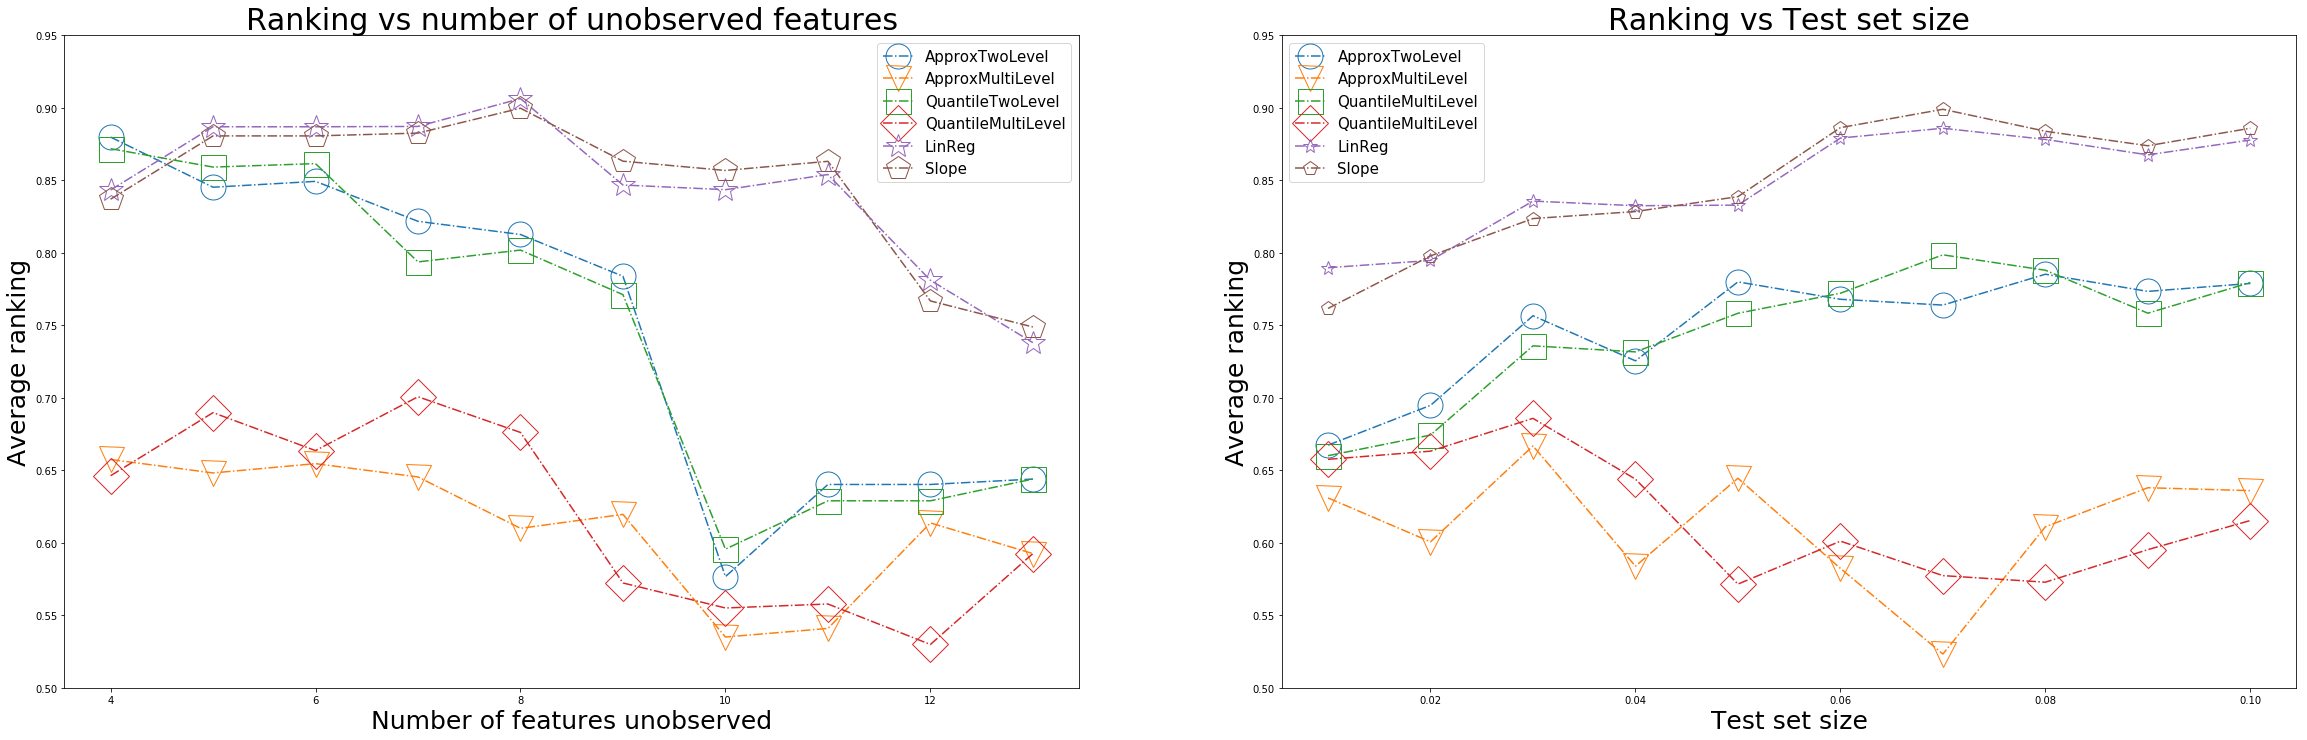

In [487]:
visualize_top_1(10,lin_rank,approx_two_rank,approx_multi_rank,quantile_two_rank,quantile_multi_rank)

## Top N Patients Normalized Discounted Cumulative Gain

**Calculate Discounted Cumulative Gain**

Formula: Sum of relevancy score / log2(i+1)

In [500]:
def top_n_dcg(dn,tn,repeat,method,pn):
    
    approx_two_dcg,approx_multi_dcg = np.zeros((dn,tn)), np.zeros((dn,tn))
    
    for drop_num in range(4,4+dn):
        for test_size in range(1,tn+1):
            ##Load corresponding pickle files
            if method == 'approx':
                if test_size == 10:
                    file_path = '../approx_result/approx__drops-{0}__test_size-0.1__batch_size-32'.format(drop_num)
                else:
                    file_path = '../approx_result/approx__drops-{0}__test_size-0.0{1}__batch_size-32'.format(drop_num,test_size)
            else:
                if test_size == 10:
                    file_path = '../quantile_result/quantile__drops-{0}__test_size-0.1__batch_size-64'.format(drop_num)
                elif test_size %2 == 1:
                    file_path = '../quantile_result/quantile__drops-{0}__test_size-0.0{1}__batch_size-32'.format(drop_num,test_size)
                else:
                    file_path = '../quantile_result/quantile__drops-{0}__test_size-0.0{1}__batch_size-64'.format(drop_num,test_size)
            
            file = pickle.load(open(file_path,'rb'))

            truth = np.asanyarray(file['truth'])
            two_preds = np.asanyarray(file['bi_preds'])
            multi_preds = np.asanyarray(file['multi_preds'])

            two_avg,multi_avg = np.zeros(10),np.zeros(10)

            for i in range(10):
                sorted_truth = sorted(truth[i])
                two_dcg,multi_dcg = 0,0

                two_top = truth[i][np.argsort(two_preds[i])[-pn:][::-1]]
                for j,value in enumerate(two_top):
                    two_max_idx = np.where(sorted_truth == value)[0][0]
                    two_dcg += (two_max_idx/len(truth[i]))/np.log2(j+1+1)

                multi_top = truth[i][np.argsort(multi_preds[i])[-pn:][::-1]]
                for j,value in enumerate(multi_top):
                    multi_max_idx = np.where(sorted_truth == value)[0][0]
                    multi_dcg += (multi_max_idx/len(truth[i]))/np.log2(j+1+1)

                two_avg[i] = two_dcg
                multi_avg[i] = multi_dcg

            approx_two_dcg[drop_num-4][test_size - 1] = np.mean(two_avg)
            approx_multi_dcg[drop_num-4][test_size - 1] = np.mean(multi_avg)
    
    return approx_two_dcg,approx_multi_dcg

In [501]:
approx_two_dcg,approx_multi_dcg = top_n_dcg(10,10,10,'approx',5)

In [502]:
quantile_two_dcg,quantile_multi_dcg = top_n_dcg(10,10,10,'quantile',5)

In [505]:
approx_two_dcg_n,approx_multi_dcg_n,quantile_two_dcg_n,quantile_multi_dcg_n,lin_dcg_n,slope_dcg_n = [],[],[],[],[],[]
for i in range(1,5):
    pn = i*5
    approx_two_dcg_temp, approx_multi_dcg_temp = top_n_dcg(10,10,10,'approx',pn)
    quantile_two_dcg_temp, quantile_multi_dcg_temp = top_n_dcg(10,10,10,'quantile',pn)
    _,lin_dcg_temp = get_linreg_values(x_train,y_train,harder_measure,10,10,10,pn,slope=True)
    _,slope_dcg_temp = get_linreg_values(x_train,y_train,harder_measure,10,10,10,pn,slope=False)
    approx_two_dcg_n.append(np.mean(approx_two_dcg_temp[-1]))
    approx_multi_dcg_n.append(np.mean(approx_multi_dcg_temp[-1]))
    quantile_two_dcg_n.append(np.mean(quantile_two_dcg_temp[-1]))
    quantile_multi_dcg_n.append(np.mean(quantile_multi_dcg_temp[-1]))
    lin_dcg_n.append(np.mean(lin_dcg_temp[-1]))
    slope_dcg_n.append(np.mean(slope_dcg_temp[-1]))

In [509]:
def visualize_dcg():
    fig,ax = plt.subplots(1,2,figsize=(40,12))
    
    drops = [i for i in range(4,14)]
    approx_two_avg_dcg = np.mean(approx_two_dcg,axis=1)
    approx_multi_avg_dcg = np.mean(approx_multi_dcg,axis=1)
    quantile_two_avg_dcg = np.mean(quantile_two_dcg,axis=1)
    quantile_multi_avg_dcg = np.mean(quantile_multi_dcg,axis=1)
    lin_avg_dcg = np.mean(lin_dcg_matrix,axis=1)
    slope_avg_dcg = np.mean(slope_dcg_matrix,axis=1)
    
    ax[0].plot(drops,approx_two_avg_dcg/5,label='ApproxTwoLevel',linestyle='-.',marker="o",markersize=25,markerfacecolor="None")
    ax[0].plot(drops,approx_multi_avg_dcg/5,label='ApproxMultiLevel',linestyle='-.',marker="v",markersize=25,markerfacecolor="None")
    ax[0].plot(drops,quantile_two_avg_dcg/5,label='QuantileMultiLevel',linestyle='-.',marker="s",markersize=25,markerfacecolor="None")
    ax[0].plot(drops,quantile_multi_avg_dcg/5,label='QuantileMultiLevel',linestyle='-.',marker="D",markersize=25,markerfacecolor="None")
    ax[0].plot(drops,lin_avg_dcg/5,label='LinReg',linestyle='-.',marker="*",markersize=25,markerfacecolor="None")
    ax[0].plot(drops,slope_avg_dcg/5,label='Slope',linestyle='-.',marker="p",markersize=25,markerfacecolor="None")
    ax[0].set_xlabel('Number of Features Unobserved',fontsize=25)
    ax[0].set_ylabel('Discounted Cumulative Gain',fontsize=25)
    ax[0].set_title('Top5 NDCG vs Number of Unobserved Features',fontsize=30)
    ax[0].legend(fontsize=15)
    
    n_patients = np.array([i*5 for i in range(1,5)])
    ax[1].plot(n_patients,approx_two_dcg_n/n_patients,label='ApproxTwoLevel',linestyle='-.',marker="o",markersize=25,markerfacecolor="None")
    ax[1].plot(n_patients,approx_multi_dcg_n/n_patients,label='ApproxMultiLevel',linestyle='-.',marker="v",markersize=25,markerfacecolor="None")
    ax[1].plot(n_patients,quantile_two_dcg_n/n_patients,label='QuantileMultiLevel',linestyle='-.',marker="s",markersize=25,markerfacecolor="None")
    ax[1].plot(n_patients,quantile_multi_dcg_n/n_patients,label='QuantileMultiLevel',linestyle='-.',marker="D",markersize=25,markerfacecolor="None")
    ax[1].plot(n_patients,lin_dcg_n/n_patients,label='LinReg',linestyle='-.',marker="*",markersize=25,markerfacecolor="None")
    ax[1].plot(n_patients,slope_dcg_n/n_patients,label='Slope',linestyle='-.',marker="p",markersize=25,markerfacecolor="None")
    ax[1].set_xlabel('Top N Patients',fontsize=25)
    ax[1].set_ylabel('Normalized Discounted Cumulative Gain',fontsize=25)
    ax[1].set_title('Top N Patients NDCG (m = 0.1)',fontsize=30)
    ax[1].legend(fontsize=15)
    
    plt.savefig('../dcg_result.png',transparent=True)
    

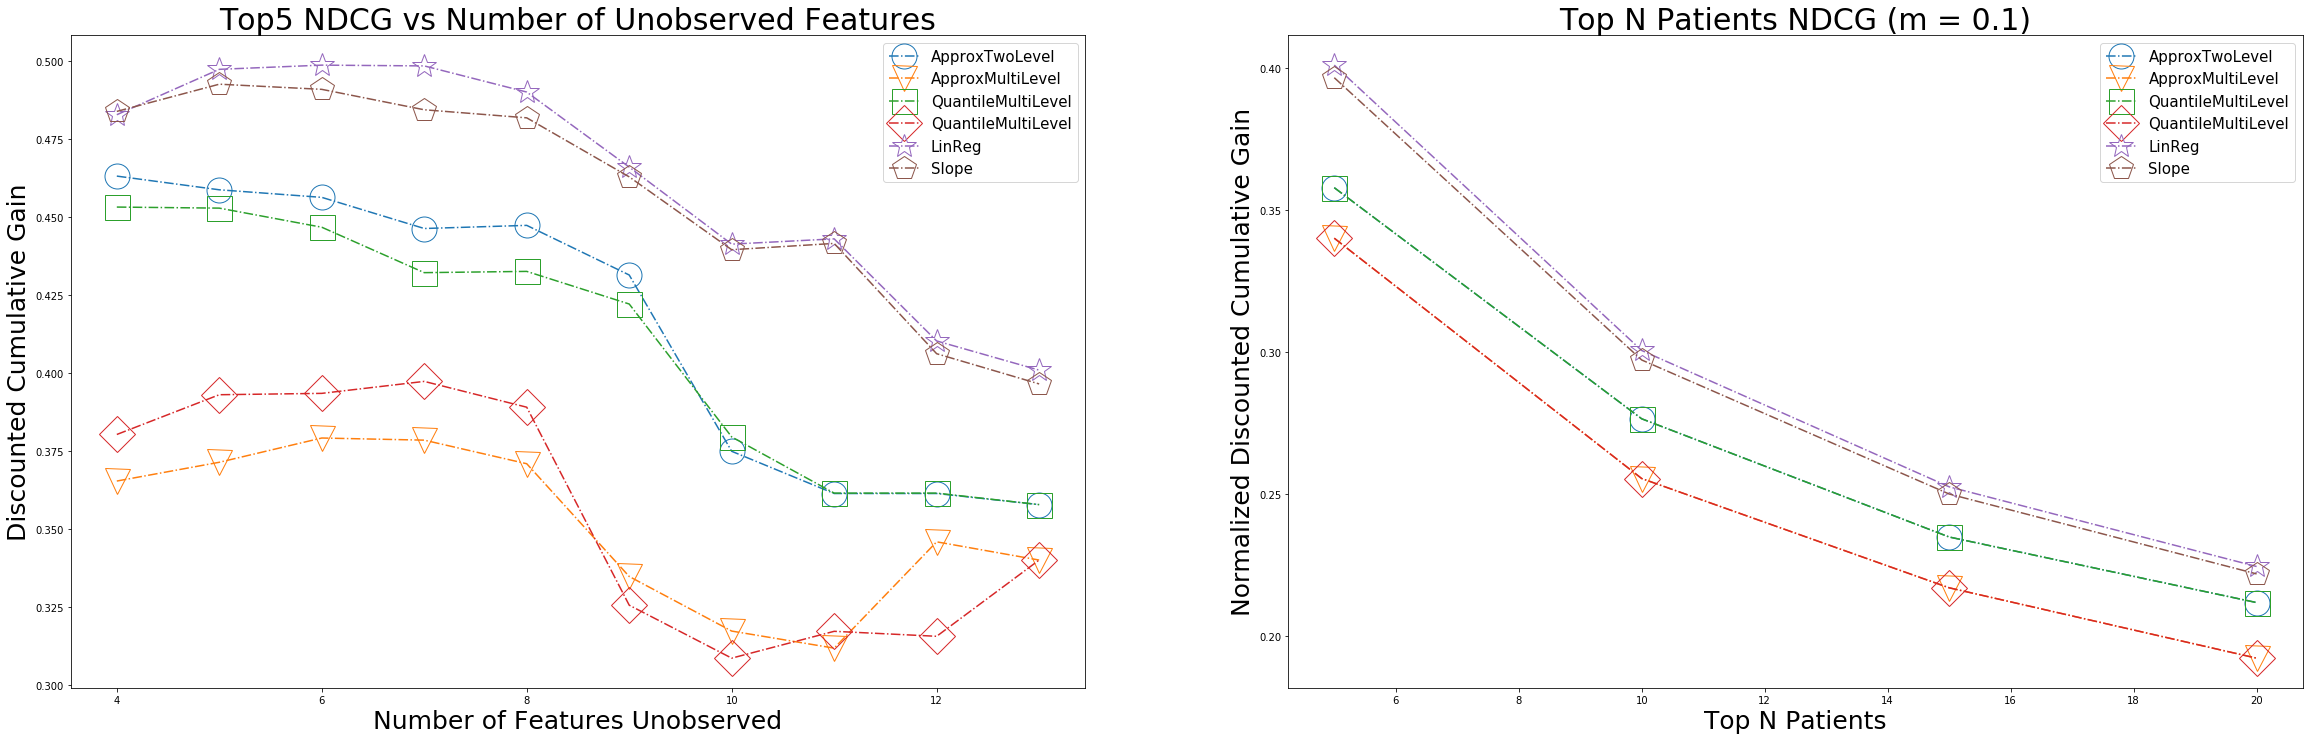

In [510]:
visualize_dcg()